In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery


In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200316
# partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)
tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

celo-testnet.transaction_metrics_exporter.transaction_metrics_exporter_20200319


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [24]:
query_blocks = f"""
SELECT 
  MAX(T.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
    T.jsonPayload.number > 1140040
  AND T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}'
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks.describe()

,blockNumber,gasUsed,gasLimit,txAmount
count,1.054000e+03,1054.000000,1054.0,1054.000000
mean,1.140604e+06,96833.778937,20000000.0,1.880455
std,3.226522e+02,61945.801996,0.0,0.330382
min,1.140041e+06,29363.000000,20000000.0,1.000000
25%,1.140327e+06,41069.000000,20000000.0,2.000000
50%,1.140602e+06,82138.000000,20000000.0,2.000000
75%,1.140883e+06,120432.000000,20000000.0,2.000000
max,1.141157e+06,528953.000000,20000000.0,3.000000


In [25]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount
0,2020-03-19 13:46:35.201118+00:00,1141157.0,120432.0,20000000.0,1
1,2020-03-19 13:46:19.588890+00:00,1141156.0,41069.0,20000000.0,1
2,2020-03-19 13:46:14.595601+00:00,1141155.0,79363.0,20000000.0,1
3,2020-03-19 13:46:09.584363+00:00,1141154.0,108726.0,20000000.0,1
4,2020-03-19 13:46:04.620721+00:00,1141153.0,79363.0,20000000.0,1


In [36]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {(last_block - first_block):.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")

last block  : 1141157 on 2020-03-19 13:46:35.201118+00:00
first block : 1140041 on 2020-03-19 11:57:47.612751+00:00
blocks load : 1116
transactions: 1982
mean gasUsed: 96834 GcWei


In [41]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.contract,
  jsonPayload.function,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.blockNumber > 1141040
  AND jsonPayload.event='{EventTypes.RECEIVED_STATE.value}'
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,goldTokenTotalSupply
count,6.080000e+02,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02
mean,1.141118e+06,6.025406e+26,1.477610e+24,1.003000e+00,2.228659e+26
std,4.503780e+01,1.100176e+20,2.706045e+17,2.227786e-16,6.894665e+10
min,1.141041e+06,6.025404e+26,1.477610e+24,1.003000e+00,2.228659e+26
25%,1.141079e+06,6.025405e+26,1.477610e+24,1.003000e+00,2.228659e+26
50%,1.141118e+06,6.025406e+26,1.477610e+24,1.003000e+00,2.228659e+26
75%,1.141156e+06,6.025407e+26,1.477610e+24,1.003000e+00,2.228659e+26
max,1.141197e+06,6.025408e+26,1.477610e+24,1.003000e+00,2.228659e+26


In [38]:
df_state.head()
df_state.tail()

,timestamp,blockNumber,contract,function,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
587,2020-03-19 13:35:33.579264+00:00,1141042.0,GoldToken,totalSupply,NaN,NaN,NaN,None,None,2.228659e+26
588,2020-03-19 13:35:29.361901+00:00,1141041.0,SortedOracles,medianRate,NaN,NaN,1.003,None,None,NaN
589,2020-03-19 13:35:29.355040+00:00,1141041.0,EpochRewards,getTargetGoldTotalSupply,6.025404e+26,NaN,NaN,None,None,NaN
590,2020-03-19 13:35:29.351367+00:00,1141041.0,EpochRewards,getRewardsMultiplier,NaN,1.477610e+24,NaN,None,None,NaN
591,2020-03-19 13:35:29.350724+00:00,1141041.0,GoldToken,totalSupply,NaN,NaN,NaN,None,None,2.228659e+26


Text(0, 0.5, 'SortedOracles.medianRate')

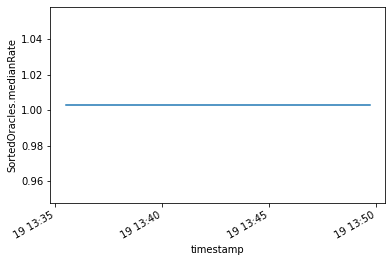

In [39]:
df_sortedOracles = df_state.set_index('timestamp')['medianRate'].dropna()
ax = df_sortedOracles.plot()
ax.set_xlabel("timestamp")
ax.set_ylabel("SortedOracles.medianRate")

In [40]:
df_stableToken = df_state.set_index('timestamp')[['currentStableBucket','currentGoldBucket']].dropna()
ax = df_stableToken.plot()
ax.set_xlabel("timestamp")

TypeError: no numeric data to plot

Text(0.5, 0, 'timestamp')

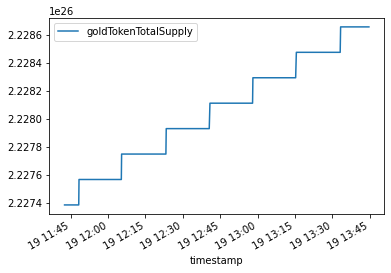

In [23]:
df_goldToken = df_state.set_index('timestamp')[['goldTokenTotalSupply']].dropna()
ax = df_goldToken.plot()
ax.set_xlabel("timestamp")